In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
import os

# Path to your folder in Google Drive
PlantVillage = '/content/drive/My Drive/PlantVillage'

# List all files in the folder
image_files = os.listdir(PlantVillage)

print("Number of images:", len(image_files))
print("Sample files:", image_files[:5])

Number of images: 3
Sample files: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']


In [7]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/PlantVillage',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size =BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [9]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [10]:
len(dataset)

68

### This means the dataset is batched by 32

In [11]:
68*32

2176

In [12]:
for image_batch, label_batch in dataset.take(1): #It take 1 batch of dataset
  print(image_batch.shape)
  print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 1 0 1 0 1 1 2 1 1 0 1 1 0 1 1 1 0 2 0 0 1 0 1 1 0 0 2]


### The label_batch is refered : -

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

         |                            |                    |
         |                            |                    |
         0                            1                    2

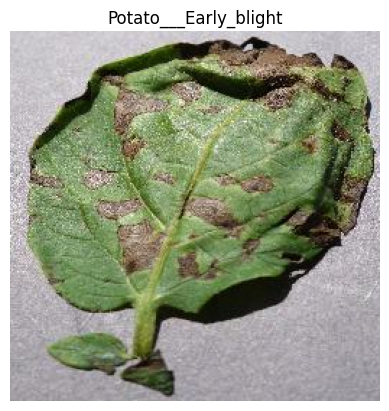

In [13]:
for image_batch, label_batch in dataset.take(1):

  plt.imshow(image_batch[0].numpy().astype('uint8'))
  plt.axis('off')
  plt.title(class_names[label_batch[0]])

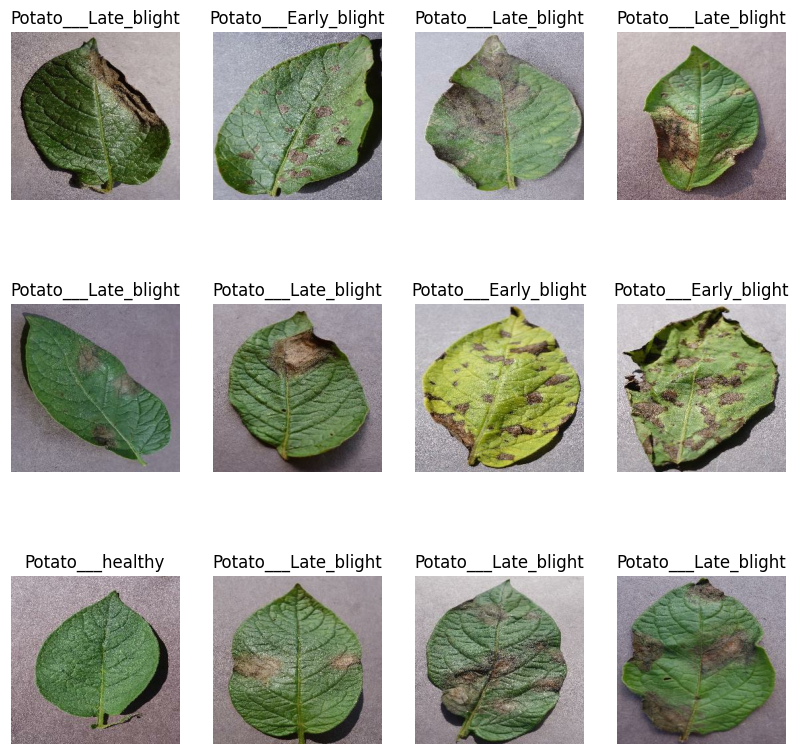

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
  for i in range(12):
    ax = plt.subplot(3, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')

In [15]:
len(dataset)

68

I want to split the dataset

80% ==> training

20% ==> 10% for validation,   10%  for test

In [16]:
train_size = 0.8  #80%
len(dataset)*train_size

54.400000000000006

In [17]:
train_ds = dataset.take(54)
len(train_ds)

54

In [18]:
test_ds = dataset.skip(54) #this like slice take skip first 54 items and take rest of 54 items (arr[54:])
len(test_ds)

14

In [19]:
val_size = 0.1  #validation size is 10%
len(dataset)*val_size  #find how many would 10% of dataset

6.800000000000001

In [20]:
val_ds = test_ds.take(6) # take the 10% items for validation
len(val_ds)

6

In [21]:
test_ds = test_ds.skip(6)  #remaining 10% take for testing
len(test_ds)

8

In [22]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, test_split=0.1, shuffle=True, shuffle_size=10000):

  ds_size = len(ds)

  if shuffle:
    ds = ds.shuffle(shuffle_size, seed=12)

  train_size = int(train_split * ds_size)
  val_size = int(val_split * ds_size)

  train_ds = ds.take(train_size)

  val_ds = ds.skip(train_size).take(val_size)

  test_ds = ds.skip(train_size).skip(val_size)

  return train_ds, val_ds, test_ds

In [23]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [24]:
len(train_ds)

54

In [25]:
len(val_ds)

13

In [26]:
len(test_ds)

1

In [27]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

cache()  stores the dataset in memory or on disk after the first read, reducing data loading times for subsequent epochs.

prefetch() ensures that while the model is training on one batch, the next batch of data is being prepared in the background.

In [35]:
resize = layers.Resizing(IMAGE_SIZE, IMAGE_SIZE)

Here i hadn't use rescale because this layers modify the input shape and values before they are passed into the next layer. When I try to input_shape define on a layer before the preprocessing layers, Keras can get confused because the shape might not align as expected. That's why i omit rescaling

In [36]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2),
])

## Use CNN

In [38]:

IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32
n_classes = 3

input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    resize,
    data_augmentation,
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing_1 (Resizing)                │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (32, 256, 256, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (32, 254, 254, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (32, 127, 127, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (32, 125, 125, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (32, 62, 62, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (32, 60, 60, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (32, 30, 30, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (32, 28, 28, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (32, 14, 14, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (32, 12, 12, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (32, 6, 6, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 4, 4, 64)              │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (32, 2, 2, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (32, 256)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 64)                    │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [40]:
historty = model.fit(
    train_ds,
    epochs=10,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 363s 5s/step - accuracy: 0.5254 - loss: 2.6412 - val_accuracy: 0.6466 - val_loss: 0.7418
Epoch 2/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.7409 - loss: 0.6136 - val_accuracy: 0.7404 - val_loss: 0.5511
Epoch 3/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.8243 - loss: 0.4078 - val_accuracy: 0.8798 - val_loss: 0.2655
Epoch 4/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - accuracy: 0.8633 - loss: 0.3123 - val_accuracy: 0.8822 - val_loss: 0.2912
Epoch 5/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 265s 5s/step - accuracy: 0.9071 - loss: 0.2416 - val_accuracy: 0.8534 - val_loss: 0.3563
Epoch 6/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 291s 5s/step - accuracy: 0.8805 - loss: 0.3130 - val_accuracy: 0.8846 - val_loss: 0.3968
Epoch 7/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 293s 5s/step - accuracy: 0.9071 - loss: 0.2387 - val_accuracy: 0.9279 - val_loss: 0.1703
Epoch 8/10
54/54 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.9308 - loss: 0.2033 - val_accuracy: 0.9375 - v

In [43]:
scores = model.evaluate(test_ds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - accuracy: 0.7812 - loss: 0.3776


In [44]:
scores

[0.3776443302631378, 0.78125]

In [45]:
historty.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [46]:
historty.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [47]:
historty.history['accuracy']

[0.5943287014961243,
 0.7696759104728699,
 0.8501157164573669,
 0.8547453880310059,
 0.8987268805503845,
 0.8865740895271301,
 0.9039351940155029,
 0.9195601940155029,
 0.9351851940155029,
 0.9322916865348816]

In [48]:
acc = historty.history['accuracy']
val_acc = historty.history['val_accuracy']

loss = historty.history['loss']
val_loss = historty.history['val_loss']

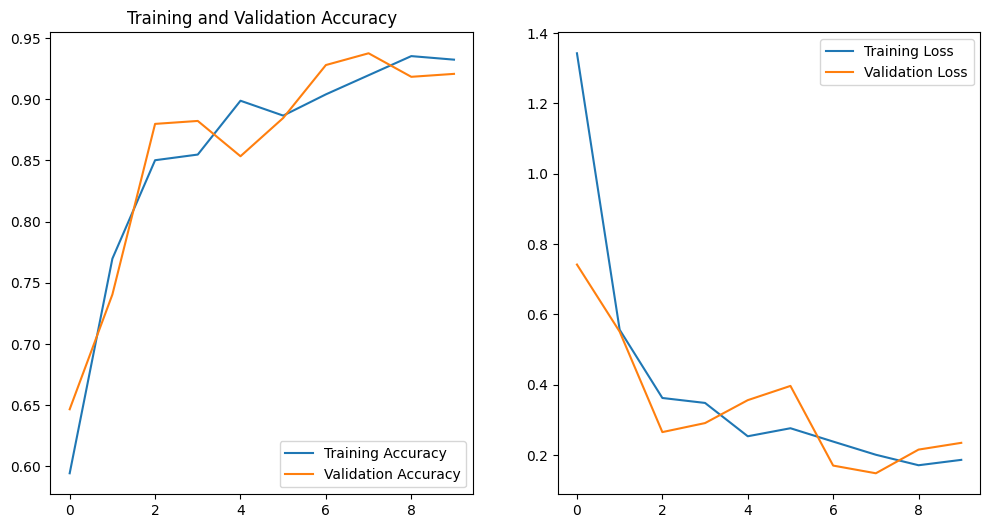

In [49]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(range(10), acc, label='Training Accuracy')
plt.plot(range(10), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(10), loss, label='Training Loss')
plt.plot(range(10), val_loss, label='Validation Loss')
plt.legend(loc='upper right')

First image to predict
Actual label: Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 990ms/step
Predicted label: Potato___Early_blight


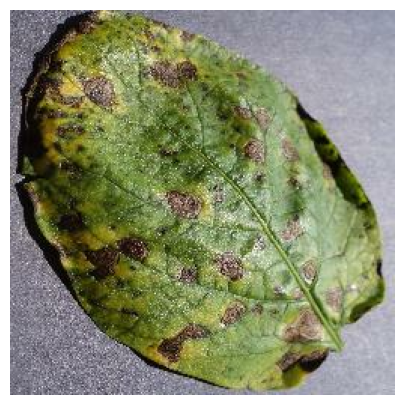

In [54]:
import numpy as np

for image_batch, label_batch in test_ds.take(1):

  first_image = image_batch[0].numpy().astype('uint8')
  first_label = label_batch[0].numpy()
  plt.figure(figsize=(5, 5))
  print('First image to predict')
  plt.imshow(first_image)
  print('Actual label:', class_names[first_label])

  batch_prediction = model.predict(image_batch)
  print('Predicted label:', class_names[tf.argmax(batch_prediction[0])])

  plt.axis('off')

In [55]:
def predict(model, img):
  img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array = tf.expand_dims(img_array, 0)

  predictions = model.predict(img_array)

  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)
  return predicted_class, confidence

In [62]:
plt.figure(figsize=(19,20))
for images, labels in test_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
    plt.axis('off')

Output hidden; open in https://colab.research.google.com to view.

In [68]:
model_version = "version_1"
model.save(f"../models/{model_version}.keras") # save model in drive's vm

In [71]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
# for manual save by type the file name
#model_version = "version_1"

#model.save(f'/content/drive/MyDrive/potato_disease_models/models/{model_version}.keras') # save model to drive models dir

In [82]:
path = '/content/drive/MyDrive/potato_disease_models/models'


# for automate the save model incremently like version_2, version_3, ...
import os
model_version = 1 + max(
    [int(f.split('_')[-1].split('.')[0]) for f in os.listdir(path) if f.startswith('version_') and f.endswith('.keras')],
    default=0
)
# Save the model
model.save(f'{path}/version_{model_version}.keras')